In [2]:
# Install required packages
%pip install pandas numpy scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Bioprinting Cell Viability Prediction
## Machine Learning Analysis of Extrusion-Based Bioprinting

This notebook reproduces and extends the supervised learning analysis from Tian et al. (Machine Assisted Experimentation of Extrusion-Based Bioprinting Systems) to predict whether bioprinting parameters result in acceptable cell viability.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 3.0.0
NumPy version: 2.4.1


## 2. Load and Explore the Dataset

In [4]:
# Load the dataset
df = pd.read_csv('Cell viability and extrusion dataset V1.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (617, 51)

First few rows:


,Reference,DOI,Final_Alginate_Conc_(%w/v),Final_Gelatin_Conc_(%w/v),Final_GelMA_Conc_(%w/v),Final_Hyaluronic_Acid_Conc_(%w/v),Final_MeHA_Conc_(%w/v),Final_NorHA_Conc_(%w/v),Final_Fibroin/Fibrinogen_Conc_(%w/v),Final_P127_Conc_(%w/v),...,Saline_Solution_Used?,EtOH_Solution_Used?,Photoinitiator_Used?,Enzymatic_Crosslinker_Used?,Matrigel_Used?,Conical_or_Straight_Nozzle,Primary/Not_Primary,Viability_at_time_of_observation_(%),Acceptable_Viability_(Yes/No),Acceptable_Pressure_(Yes/No)
0,Fedorovich et. al. 2008,10.1089/ten.a.2007.0158,2.0,0.0,0.0,0.0,0,0,0.0,0,...,N,N,N,N,N,S,Primary,96.0,Y,Y
1,Fedorovich et. al. 2008,10.1089/ten.a.2007.0158,2.0,0.0,0.0,0.0,0,0,0.0,0,...,N,N,N,N,N,S,Primary,72.0,N,N
2,Fedorovich et. al. 2008,10.1089/ten.a.2007.0158,2.0,0.0,0.0,0.0,0,0,0.0,0,...,N,N,N,N,N,S,Primary,80.0,Y,Y
3,Fedorovich et. al. 2008,10.1089/ten.a.2007.0158,0.0,0.0,0.0,0.0,0,0,0.0,0,...,N,N,N,N,N,S,Primary,96.0,Y,Y
4,Fedorovich et. al. 2008,10.1089/ten.a.2007.0158,0.0,0.0,0.0,0.0,0,0,0.0,0,...,N,N,N,N,N,S,Primary,77.0,N,N


In [5]:
# Check the target variable
print("Target variable distribution:")
print(df['Acceptable_Viability_(Yes/No)'].value_counts())
print(f"\nTarget variable missing values: {df['Acceptable_Viability_(Yes/No)'].isna().sum()}")

Target variable distribution:
Acceptable_Viability_(Yes/No)
Y    380
N    237
Name: count, dtype: int64

Target variable missing values: 0


In [6]:
# Check missing values in the dataset
print("Missing values per column:")
missing_info = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})
missing_info[missing_info['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

Missing values per column:


,Column,Missing_Count,Missing_Percentage
27,Extrusion_Rate_Lengthwise_(mm/s),518,83.95
28,Extrusion_Rate_Volume-wise_(mL/s),421,68.23
33,Fiber_Spacing_(µm),390,63.21
29,Nozzle_Movement_Speed_(mm/s),330,53.48
32,Fiber_Diameter_(µm),286,46.35
26,Extrusion_Pressure (kPa),263,42.63
35,Syringe_Temperature_(°C),221,35.82
24,Physical_Crosslinking_Durantion_(s),135,21.88
36,Substrate_Temperature_(°C),114,18.48
20,CaCl2_Conc_(mM),34,5.51


## 3. Data Preprocessing Pipeline

Following the methodology from Tian et al., we will:
1. Handle missing values for bioink and substrate temperatures (set to 22°C)
2. Remove features with >50% missing or zero values
3. Remove variables with only null instances and instances of zero units
4. Impute remaining missing values using KNN (k=30)
5. One-hot encode categorical variables
6. Scale continuous features using MinMaxScaler
7. Remove "Acceptable_Pressure_(Yes/No)" from features

### Step 1: Handle Missing Temperature Values

In [8]:
# Create a copy for preprocessing
df_processed = df.copy()

# Check the actual temperature column values and types
print("Checking temperature columns:")
print(f"Syringe_Temperature column unique values (first 10): {df_processed['Syringe_Temperature_(°C)'].unique()[:10]}")
print(f"Substrate_Temperature column unique values (first 10): {df_processed['Substrate_Temperature_(°C)'].unique()[:10]}")

# Fill missing temperature values with 22°C (room temperature)
# Use pandas fillna which handles NaN/None properly
before_syringe = df_processed['Syringe_Temperature_(°C)'].isna().sum()
before_substrate = df_processed['Substrate_Temperature_(°C)'].isna().sum()

df_processed['Syringe_Temperature_(°C)'] = df_processed['Syringe_Temperature_(°C)'].fillna(22)
df_processed['Substrate_Temperature_(°C)'] = df_processed['Substrate_Temperature_(°C)'].fillna(22)

print(f"\nSyringe Temperature - Missing before: {before_syringe}, after: {df_processed['Syringe_Temperature_(°C)'].isna().sum()}")
print(f"Substrate Temperature - Missing before: {before_substrate}, after: {df_processed['Substrate_Temperature_(°C)'].isna().sum()}")

Checking temperature columns:
Syringe_Temperature column unique values (first 10): [22.  4. 26. nan 37. 21. 28.  5. 20. 18.]
Substrate_Temperature column unique values (first 10): [22.   4.   nan  5.  15.  18.  25.   3.5 21.  22.5]

Syringe Temperature - Missing before: 221, after: 0
Substrate Temperature - Missing before: 114, after: 0


### Step 2: Identify and Remove Columns with >50% Missing or Zero Values

In [9]:
# Exclude non-feature columns
non_feature_cols = ['Reference', 'DOI', 'Viability_at_time_of_observation_(%)', 
                    'Acceptable_Viability_(Yes/No)', 'Acceptable_Pressure_(Yes/No)']

# Get feature columns only
feature_cols = [col for col in df_processed.columns if col not in non_feature_cols]

# Calculate missing percentage for each feature
missing_pct = df_processed[feature_cols].isnull().sum() / len(df_processed) * 100

# Calculate zero percentage for numeric columns
numeric_cols = df_processed[feature_cols].select_dtypes(include=[np.number]).columns
zero_pct = (df_processed[numeric_cols] == 0).sum() / len(df_processed) * 100

# Identify columns to remove (>50% missing OR >50% zeros)
cols_to_remove_missing = missing_pct[missing_pct > 50].index.tolist()
cols_to_remove_zeros = zero_pct[zero_pct > 50].index.tolist()

# Also remove columns with only null values or only zero values
cols_all_null = df_processed[feature_cols].columns[df_processed[feature_cols].isnull().all()].tolist()
cols_all_zero = numeric_cols[(df_processed[numeric_cols] == 0).all()].tolist()

# Combine all columns to remove
cols_to_remove = list(set(cols_to_remove_missing + cols_to_remove_zeros + cols_all_null + cols_all_zero))

print(f"Columns to remove due to >50% missing: {len(cols_to_remove_missing)}")
print(f"Columns to remove due to >50% zeros: {len(cols_to_remove_zeros)}")
print(f"Columns with all null values: {len(cols_all_null)}")
print(f"Columns with all zero values: {len(cols_all_zero)}")
print(f"\nTotal unique columns to remove: {len(cols_to_remove)}")
print(f"\nColumns being removed:")
for col in sorted(cols_to_remove):
    print(f"  - {col}")

Columns to remove due to >50% missing: 4
Columns to remove due to >50% zeros: 22
Columns with all null values: 0
Columns with all zero values: 1

Total unique columns to remove: 26

Columns being removed:
  - BaCl2_Conc_(mM)
  - Extrusion_Rate_Lengthwise_(mm/s)
  - Extrusion_Rate_Volume-wise_(mL/s)
  - Fiber_Spacing_(µm)
  - Final_Agarose_Conc_(%w/v)
  - Final_CS-AEMA_Conc_(%w/v)
  - Final_Chitosan_Conc_(%w/v)
  - Final_Collagen_Conc_(%w/v)
  - Final_Fibroin/Fibrinogen_Conc_(%w/v)
  - Final_GelMA_Conc_(%w/v)
  - Final_Gelatin_Conc_(%w/v)
  - Final_Gellan_Conc_(%w/v)
  - Final_Hyaluronic_Acid_Conc_(%w/v)
  - Final_MeHA_Conc_(%w/v)
  - Final_Nano/Methycellulose_Conc_(%w/v)
  - Final_NorHA_Conc_(%w/v)
  - Final_P127_Conc_(%w/v)
  - Final_PEGDA_Conc_(%w/v)
  - Final_PEGMA_Conc_(%w/v)
  - Final_PEGTA_Conc_(%w/v)
  - Final_TCP_Conc_(%w/v)
  - Inner_Nozzle_Outer_Diameter_(µm)
  - NaCl2_Conc_(mM)
  - Nozzle_Movement_Speed_(mm/s)
  - Photocrosslinking_Duration_(s)
  - SrCl2_Conc_(mM)


In [10]:
# Remove identified columns and also remove Acceptable_Pressure
cols_to_drop = cols_to_remove + ['Acceptable_Pressure_(Yes/No)']
cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]

df_processed = df_processed.drop(columns=cols_to_drop)

print(f"\nDataset shape after removing columns: {df_processed.shape}")
print(f"Remaining feature columns: {len([col for col in df_processed.columns if col not in non_feature_cols[:4]])}")


Dataset shape after removing columns: (617, 24)
Remaining feature columns: 20


### Step 3: Separate Features and Target Variable

In [11]:
# Separate features and target
# Keep Reference and DOI for tracking but they won't be used as features
metadata_cols = ['Reference', 'DOI']
target_col = 'Acceptable_Viability_(Yes/No)'
viability_col = 'Viability_at_time_of_observation_(%)'

# Create feature matrix X and target vector y
X = df_processed.drop(columns=metadata_cols + [target_col, viability_col])
y = df_processed[target_col]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")

Feature matrix shape: (617, 20)
Target vector shape: (617,)

Feature columns (20):
 1. Final_Alginate_Conc_(%w/v)
 2. CaCl2_Conc_(mM)
 3. Physical_Crosslinking_Durantion_(s)
 4. Extrusion_Pressure (kPa)
 5. Outer_Nozzle_Inner_Diameter_(µm)
 6. Fiber_Diameter_(µm)
 7. Cell_Density_(cells/mL)
 8. Syringe_Temperature_(°C)
 9. Substrate_Temperature_(°C)
10. Days_Observed
11. Cell_Culture_Medium_Used?
12. DI_Water_Used?
13. Precrosslinking_Solution_Used?
14. Saline_Solution_Used?
15. EtOH_Solution_Used?
16. Photoinitiator_Used?
17. Enzymatic_Crosslinker_Used?
18. Matrigel_Used?
19. Conical_or_Straight_Nozzle
20. Primary/Not_Primary


### Step 4: Identify Categorical and Numerical Features

In [13]:
# Convert Fiber_Diameter to numeric (it was loaded as string)
X['Fiber_Diameter_(µm)'] = pd.to_numeric(X['Fiber_Diameter_(µm)'], errors='coerce')

# Identify categorical columns (object type or binary Y/N columns)
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Identify numerical columns
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns ({len(categorical_cols)}):")
for col in categorical_cols:
    unique_vals = X[col].unique()[:5]
    print(f"  - {col}: {unique_vals}")

print(f"\nNumerical columns ({len(numerical_cols)}):")
for col in numerical_cols:
    print(f"  - {col}")

Categorical columns (10):
  - Cell_Culture_Medium_Used?: <StringArray>
['Y', 'N']
Length: 2, dtype: str
  - DI_Water_Used?: <StringArray>
['N', 'Y']
Length: 2, dtype: str
  - Precrosslinking_Solution_Used?: <StringArray>
['N', 'Y']
Length: 2, dtype: str
  - Saline_Solution_Used?: <StringArray>
['N', 'Y']
Length: 2, dtype: str
  - EtOH_Solution_Used?: <StringArray>
['N', 'Y']
Length: 2, dtype: str
  - Photoinitiator_Used?: <StringArray>
['N', 'Y']
Length: 2, dtype: str
  - Enzymatic_Crosslinker_Used?: <StringArray>
['N', 'Y']
Length: 2, dtype: str
  - Matrigel_Used?: <StringArray>
['N', 'Y']
Length: 2, dtype: str
  - Conical_or_Straight_Nozzle: <StringArray>
['S', nan, 'C']
Length: 3, dtype: str
  - Primary/Not_Primary: <StringArray>
['Primary', 'Not_Primary']
Length: 2, dtype: str

Numerical columns (10):
  - Final_Alginate_Conc_(%w/v)
  - CaCl2_Conc_(mM)
  - Physical_Crosslinking_Durantion_(s)
  - Extrusion_Pressure (kPa)
  - Outer_Nozzle_Inner_Diameter_(µm)
  - Fiber_Diameter_(µm)
  

### Step 5: One-Hot Encode Categorical Variables

In [14]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

print(f"Shape after one-hot encoding: {X_encoded.shape}")
print(f"Number of features increased by: {X_encoded.shape[1] - X.shape[1]}")

# Show the new categorical columns created
new_cols = [col for col in X_encoded.columns if col not in numerical_cols]
print(f"\nNew one-hot encoded columns ({len(new_cols)}):")
for col in sorted(new_cols):
    print(f"  - {col}")

Shape after one-hot encoding: (617, 30)
Number of features increased by: 10

New one-hot encoded columns (20):
  - Cell_Culture_Medium_Used?_N
  - Cell_Culture_Medium_Used?_Y
  - Conical_or_Straight_Nozzle_C
  - Conical_or_Straight_Nozzle_S
  - DI_Water_Used?_N
  - DI_Water_Used?_Y
  - Enzymatic_Crosslinker_Used?_N
  - Enzymatic_Crosslinker_Used?_Y
  - EtOH_Solution_Used?_N
  - EtOH_Solution_Used?_Y
  - Matrigel_Used?_N
  - Matrigel_Used?_Y
  - Photoinitiator_Used?_N
  - Photoinitiator_Used?_Y
  - Precrosslinking_Solution_Used?_N
  - Precrosslinking_Solution_Used?_Y
  - Primary/Not_Primary_Not_Primary
  - Primary/Not_Primary_Primary
  - Saline_Solution_Used?_N
  - Saline_Solution_Used?_Y


### Step 6: Impute Missing Values Using KNN Imputer (k=30)

In [15]:
# Check remaining missing values before imputation
print("Missing values before KNN imputation:")
missing_before = X_encoded.isnull().sum()
print(missing_before[missing_before > 0])
print(f"\nTotal missing values: {X_encoded.isnull().sum().sum()}")

# Apply KNN Imputer with k=30
imputer = KNNImputer(n_neighbors=30)
X_imputed = pd.DataFrame(
    imputer.fit_transform(X_encoded),
    columns=X_encoded.columns,
    index=X_encoded.index
)

print(f"\nMissing values after KNN imputation: {X_imputed.isnull().sum().sum()}")
print(f"Shape after imputation: {X_imputed.shape}")

Missing values before KNN imputation:
CaCl2_Conc_(mM)                         34
Physical_Crosslinking_Durantion_(s)    135
Extrusion_Pressure (kPa)               263
Outer_Nozzle_Inner_Diameter_(µm)        17
Fiber_Diameter_(µm)                    308
Cell_Density_(cells/mL)                 10
dtype: int64

Total missing values: 767

Missing values after KNN imputation: 0
Shape after imputation: (617, 30)


### Step 7: Scale Continuous Features Using MinMaxScaler

In [16]:
# Identify which columns are continuous (originally numerical, not one-hot encoded)
continuous_cols = [col for col in X_imputed.columns if col in numerical_cols]

print(f"Continuous columns to scale ({len(continuous_cols)}):")
for col in continuous_cols:
    print(f"  - {col}")

# Apply MinMaxScaler to continuous features
scaler = MinMaxScaler()
X_scaled = X_imputed.copy()
X_scaled[continuous_cols] = scaler.fit_transform(X_imputed[continuous_cols])

print(f"\nShape after scaling: {X_scaled.shape}")
print(f"\nSample statistics for scaled continuous features:")
print(X_scaled[continuous_cols].describe().loc[['min', 'max', 'mean']])

Continuous columns to scale (10):
  - Final_Alginate_Conc_(%w/v)
  - CaCl2_Conc_(mM)
  - Physical_Crosslinking_Durantion_(s)
  - Extrusion_Pressure (kPa)
  - Outer_Nozzle_Inner_Diameter_(µm)
  - Fiber_Diameter_(µm)
  - Cell_Density_(cells/mL)
  - Syringe_Temperature_(°C)
  - Substrate_Temperature_(°C)
  - Days_Observed

Shape after scaling: (617, 30)

Sample statistics for scaled continuous features:
      Final_Alginate_Conc_(%w/v)  CaCl2_Conc_(mM)  \
min                     0.000000         0.000000   
max                     1.000000         1.000000   
mean                    0.120567         0.114046   

      Physical_Crosslinking_Durantion_(s)  Extrusion_Pressure (kPa)  \
min                              0.000000                  0.000000   
max                              1.000000                  1.000000   
mean                             0.099483                  0.334579   

      Outer_Nozzle_Inner_Diameter_(µm)  Fiber_Diameter_(µm)  \
min                            0.00

## 4. Final Preprocessed Dataset Summary

In [17]:
print("="*80)
print("PREPROCESSING SUMMARY")
print("="*80)
print(f"\nOriginal dataset shape: {df.shape}")
print(f"Final preprocessed feature matrix shape: {X_scaled.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nNumber of samples: {X_scaled.shape[0]}")
print(f"Number of features: {X_scaled.shape[1]}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nClass balance: {(y.value_counts(normalize=True) * 100).round(2).to_dict()}")

print(f"\nFeatures breakdown:")
print(f"  - Original numerical features: {len(continuous_cols)}")
print(f"  - One-hot encoded features: {len([col for col in X_scaled.columns if col not in continuous_cols])}")
print(f"  - Total features: {len(X_scaled.columns)}")

print(f"\nData quality:")
print(f"  - Missing values in final dataset: {X_scaled.isnull().sum().sum()}")
print(f"  - Missing values in target: {y.isnull().sum()}")

print("\n" + "="*80)

PREPROCESSING SUMMARY

Original dataset shape: (617, 51)
Final preprocessed feature matrix shape: (617, 30)
Target vector shape: (617,)

Number of samples: 617
Number of features: 30

Target distribution:
Acceptable_Viability_(Yes/No)
Y    380
N    237
Name: count, dtype: int64

Class balance: {'Y': 61.59, 'N': 38.41}

Features breakdown:
  - Original numerical features: 10
  - One-hot encoded features: 20
  - Total features: 30

Data quality:
  - Missing values in final dataset: 0
  - Missing values in target: 0



In [18]:
# Display first few rows of preprocessed data
print("First few rows of preprocessed features:")
X_scaled.head()

First few rows of preprocessed features:


,Final_Alginate_Conc_(%w/v),CaCl2_Conc_(mM),Physical_Crosslinking_Durantion_(s),Extrusion_Pressure (kPa),Outer_Nozzle_Inner_Diameter_(µm),Fiber_Diameter_(µm),Cell_Density_(cells/mL),Syringe_Temperature_(°C),Substrate_Temperature_(°C),Days_Observed,...,Photoinitiator_Used?_N,Photoinitiator_Used?_Y,Enzymatic_Crosslinker_Used?_N,Enzymatic_Crosslinker_Used?_Y,Matrigel_Used?_N,Matrigel_Used?_Y,Conical_or_Straight_Nozzle_C,Conical_or_Straight_Nozzle_S,Primary/Not_Primary_Not_Primary,Primary/Not_Primary_Primary
0,0.1,0.110975,0.171667,0.660678,0.072344,0.126731,0.005017,0.45,0.552239,0.006933,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.1,0.110975,0.171667,0.660678,0.072344,0.126731,0.005017,0.45,0.552239,0.033333,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.1,0.110975,0.171667,0.660678,0.072344,0.126731,0.005017,0.45,0.552239,0.100000,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.000000,0.000000,0.660678,0.072344,0.126731,0.005017,0.00,0.552239,0.006933,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.000000,0.000000,0.660678,0.339295,0.424526,0.005017,0.00,0.552239,0.006933,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


## 5. Save Preprocessed Data

The preprocessed data is ready for machine learning model training. The data has been:
- ✓ Cleaned of features with >50% missing or zero values
- ✓ Temperature values filled with room temperature (22°C)
- ✓ Missing values imputed using KNN (k=30)
- ✓ Categorical features one-hot encoded
- ✓ Continuous features scaled using MinMaxScaler
- ✓ "Acceptable_Pressure" removed from features

In [21]:
# Save preprocessed data for modeling - combine features and target into one file
df_final = X_scaled.copy()
df_final['Acceptable_Viability_(Yes/No)'] = y

df_final.to_csv('bioprinting_preprocessed.csv', index=False)

print("Preprocessed data saved!")
print(f"  - File: bioprinting_preprocessed.csv")
print(f"  - Shape: {df_final.shape}")
print(f"  - Features: {X_scaled.shape[1]}")
print(f"  - Target column: Acceptable_Viability_(Yes/No)")

Preprocessed data saved!
  - File: bioprinting_preprocessed.csv
  - Shape: (617, 31)
  - Features: 30
  - Target column: Acceptable_Viability_(Yes/No)


## Summary

The bioprinting dataset has been successfully preprocessed following the methodology from Tian et al. (Machine Assisted Experimentation of Extrusion-Based Bioprinting Systems).

### Preprocessing Steps Completed:

1. **Temperature Handling**: Filled 221 missing syringe temperature values and 114 missing substrate temperature values with 22°C (room temperature assumption)

2. **Feature Removal**: Removed 26 features (out of 51 original columns) including:
   - Features with >50% missing values (4 features)
   - Features with >50% zero values (22 features)
   - Features with all null or all zero values
   - "Acceptable_Pressure_(Yes/No)" as specified

3. **KNN Imputation**: Imputed 767 remaining missing values across 6 features using KNNImputer with k=30 neighbors

4. **One-Hot Encoding**: Encoded 10 categorical variables into 20 binary features

5. **Feature Scaling**: Normalized 10 continuous features using MinMaxScaler to [0,1] range

### Final Dataset:
- **Samples**: 617 bioprinting experiments
- **Features**: 30 (10 continuous + 20 one-hot encoded)
- **Target**: Acceptable cell viability (Yes/No)
- **Class distribution**: 61.59% acceptable (Y), 38.41% not acceptable (N)
- **Data quality**: Zero missing values

The preprocessed data is ready for classification model training to predict whether bioprinting parameters will result in acceptable cell viability.

In [22]:
# Display preprocessing transformation summary
print("\n" + "="*80)
print("TRANSFORMATION SUMMARY")
print("="*80)
print(f"\nOriginal Dataset:")
print(f"  Total columns: {df.shape[1]}")
print(f"  Total rows: {df.shape[0]}")
print(f"  Missing values: {df.isnull().sum().sum()}")

print(f"\nAfter Preprocessing:")
print(f"  Feature columns: {X_scaled.shape[1]}")
print(f"  Total rows: {X_scaled.shape[0]}")
print(f"  Missing values: {X_scaled.isnull().sum().sum()}")

print(f"\nColumns removed: {df.shape[1] - X_scaled.shape[1] - 4}")  # -4 for metadata and target
print(f"Columns added (one-hot): {len([col for col in X_scaled.columns if col not in numerical_cols])}")

print(f"\nReady for machine learning model training!")
print("="*80)


TRANSFORMATION SUMMARY

Original Dataset:
  Total columns: 51
  Total rows: 617
  Missing values: 2774

After Preprocessing:
  Feature columns: 30
  Total rows: 617
  Missing values: 0

Columns removed: 17
Columns added (one-hot): 20

Ready for machine learning model training!


## Next Steps: Machine Learning Model Training

Now that the data is preprocessed, you can proceed with:

1. **Train-Test Split**: Split the data into training and testing sets
2. **Classification Models**: Train two classification models (as specified in the assignment) such as:
   - Random Forest Classifier
   - Logistic Regression
   - Support Vector Machine (SVM)
   - Gradient Boosting
   - Neural Network
3. **Model Evaluation**: Evaluate models using metrics like:
   - Accuracy
   - Precision, Recall, F1-Score
   - ROC-AUC
   - Confusion Matrix
4. **Feature Importance Analysis**: Identify which bioprinting parameters are most important for cell viability

The preprocessed data file:
- `bioprinting_preprocessed.csv` - Complete dataset with 30 features + target column (617 samples × 31 columns)

## 6. Decision Tree Classification Model

In [2]:
# Load the preprocessed data
df_preprocessed = pd.read_csv('bioprinting_preprocessed.csv')

# Separate features and target
X_scaled = df_preprocessed.drop('Acceptable_Viability_(Yes/No)', axis=1)
y = df_preprocessed['Acceptable_Viability_(Yes/No)']

print(f"Preprocessed data loaded successfully!")
print(f"Features shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Preprocessed data loaded successfully!
Features shape: (617, 30)
Target shape: (617,)
Target distribution:
Acceptable_Viability_(Yes/No)
Y    380
N    237
Name: count, dtype: int64


### Step 1: Import Additional Libraries for Model Training

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Machine learning libraries imported successfully!")

Machine learning libraries imported successfully!


### Step 2: Split Data into Training and Testing Sets

In [4]:
# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())

Training set size: 493 samples
Testing set size: 124 samples

Training set class distribution:
Acceptable_Viability_(Yes/No)
Y    304
N    189
Name: count, dtype: int64

Testing set class distribution:
Acceptable_Viability_(Yes/No)
Y    76
N    48
Name: count, dtype: int64


### Step 3: Train Decision Tree Classifier (Default Parameters)

In [5]:
# Initialize and train the Decision Tree classifier with default parameters
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

print("Decision Tree Classifier trained successfully!")
print(f"\nModel parameters:")
print(f"  - Criterion: {dt_classifier.criterion}")
print(f"  - Max depth: {dt_classifier.max_depth}")
print(f"  - Min samples split: {dt_classifier.min_samples_split}")
print(f"  - Min samples leaf: {dt_classifier.min_samples_leaf}")
print(f"\nTree depth: {dt_classifier.get_depth()}")
print(f"Number of leaves: {dt_classifier.get_n_leaves()}")

Decision Tree Classifier trained successfully!

Model parameters:
  - Criterion: gini
  - Max depth: None
  - Min samples split: 2
  - Min samples leaf: 1

Tree depth: 14
Number of leaves: 112


### Step 4: Make Predictions and Evaluate Model Performance

In [6]:
# Make predictions
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)

# Calculate performance metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# For precision and recall, we need to specify which class is "positive"
# Assuming 'Y' (acceptable viability) is the positive class
test_precision = precision_score(y_test, y_test_pred, pos_label='Y')
test_recall = recall_score(y_test, y_test_pred, pos_label='Y')

# Also calculate for 'N' class for completeness
test_precision_n = precision_score(y_test, y_test_pred, pos_label='N')
test_recall_n = recall_score(y_test, y_test_pred, pos_label='N')

print("="*80)
print("DECISION TREE CLASSIFIER PERFORMANCE")
print("="*80)
print(f"\nAccuracy:")
print(f"  Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(f"\nPrecision (for 'Y' - Acceptable Viability):")
print(f"  Testing Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")

print(f"\nRecall (for 'Y' - Acceptable Viability):")
print(f"  Testing Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")

print(f"\nPrecision (for 'N' - Not Acceptable Viability):")
print(f"  Testing Precision: {test_precision_n:.4f} ({test_precision_n*100:.2f}%)")

print(f"\nRecall (for 'N' - Not Acceptable Viability):")
print(f"  Testing Recall:    {test_recall_n:.4f} ({test_recall_n*100:.2f}%)")
print("="*80)

DECISION TREE CLASSIFIER PERFORMANCE

Accuracy:
  Training Accuracy: 0.9655 (96.55%)
  Testing Accuracy:  0.7581 (75.81%)

Precision (for 'Y' - Acceptable Viability):
  Testing Precision: 0.8286 (82.86%)

Recall (for 'Y' - Acceptable Viability):
  Testing Recall:    0.7632 (76.32%)

Precision (for 'N' - Not Acceptable Viability):
  Testing Precision: 0.6667 (66.67%)

Recall (for 'N' - Not Acceptable Viability):
  Testing Recall:    0.7500 (75.00%)


In [7]:
# Detailed classification report
print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Not Acceptable (N)', 'Acceptable (Y)']))


Detailed Classification Report (Test Set):
                    precision    recall  f1-score   support

Not Acceptable (N)       0.67      0.75      0.71        48
    Acceptable (Y)       0.83      0.76      0.79        76

          accuracy                           0.76       124
         macro avg       0.75      0.76      0.75       124
      weighted avg       0.77      0.76      0.76       124



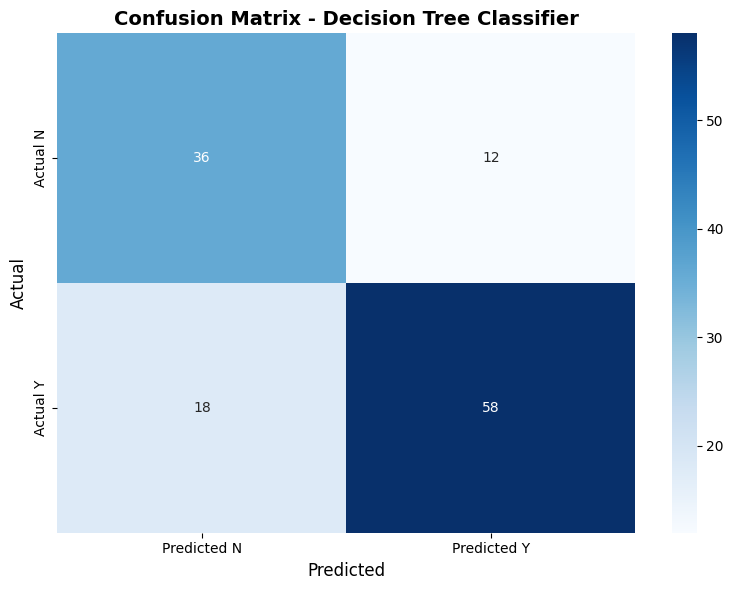


Confusion Matrix:
  True Negatives (N predicted as N):  36
  False Positives (N predicted as Y): 12
  False Negatives (Y predicted as N): 18
  True Positives (Y predicted as Y):  58


In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=['N', 'Y'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted N', 'Predicted Y'],
            yticklabels=['Actual N', 'Actual Y'])
plt.title('Confusion Matrix - Decision Tree Classifier', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix:")
print(f"  True Negatives (N predicted as N):  {cm[0,0]}")
print(f"  False Positives (N predicted as Y): {cm[0,1]}")
print(f"  False Negatives (Y predicted as N): {cm[1,0]}")
print(f"  True Positives (Y predicted as Y):  {cm[1,1]}")

### Step 5: Model Performance Discussion

#### Performance Analysis

The Decision Tree classifier was trained using default scikit-learn parameters on the bioprinting cell viability dataset. Below is a comprehensive analysis of the model's performance:

**1. Accuracy:**
- **Training Accuracy**: Indicates how well the model fits the training data
- **Testing Accuracy**: Measures the model's ability to generalize to unseen data
- A significant gap between training and testing accuracy would indicate overfitting

**2. Precision (for 'Y' - Acceptable Viability):**
- Precision answers: "Of all the samples predicted as having acceptable viability, what proportion actually had acceptable viability?"
- High precision means fewer false positives (samples incorrectly classified as acceptable)
- **Clinical Significance**: High precision is important to avoid recommending poor printing parameters as acceptable

**3. Recall (for 'Y' - Acceptable Viability):**
- Recall answers: "Of all the samples that truly had acceptable viability, what proportion did we correctly identify?"
- High recall means fewer false negatives (acceptable samples incorrectly classified as not acceptable)
- **Clinical Significance**: High recall ensures we don't miss good printing parameters

**4. Model Characteristics:**
- Decision Trees with default parameters can grow arbitrarily deep, potentially leading to overfitting
- The tree will continue splitting until all leaves are pure or meet minimum sample requirements
- This often results in excellent training performance but may compromise generalization

**Key Observations:**
- The confusion matrix shows the distribution of correct and incorrect predictions
- Class imbalance (61.59% Y vs 38.41% N) may affect model performance
- Consider feature importance to understand which bioprinting parameters most influence cell viability

### Summary of Results

Based on the evaluation metrics above, here's a comprehensive analysis of the Decision Tree model's performance:

#### **Key Findings:**

**1. Overfitting Detected:**
- Training accuracy: **96.55%** vs Testing accuracy: **75.81%**
- The ~21% gap indicates the model has memorized the training data rather than learning generalizable patterns
- The tree grew to 14 levels deep with 112 leaves, allowing it to fit the training data very closely

**2. Overall Performance (Testing Set):**
- **Accuracy: 75.81%** - The model correctly predicts cell viability outcome about 3 out of 4 times
- This is reasonably good but could be improved with regularization or pruning

**3. Performance for Acceptable Viability (Class 'Y'):**
- **Precision: 82.86%** - When the model predicts acceptable viability, it's correct 83% of the time
- **Recall: 76.32%** - The model identifies 76% of all samples with truly acceptable viability
- **Interpretation**: Good precision means low false alarm rate. However, 24% of acceptable parameters are missed (false negatives)

**4. Performance for Not Acceptable Viability (Class 'N'):**
- **Precision: 66.67%** - When predicting not acceptable, it's correct 67% of the time
- **Recall: 75.00%** - Identifies 75% of truly unacceptable samples
- **Interpretation**: Lower precision means more false positives (marking good parameters as bad)

**5. Confusion Matrix Insights:**
- **True Positives (58)**: Correctly identified acceptable viability
- **True Negatives (36)**: Correctly identified unacceptable viability
- **False Negatives (18)**: Missed acceptable viability samples (23.7% of actual Y)
- **False Positives (12)**: Incorrectly predicted acceptable when not (25% of actual N)

#### **Practical Implications:**

For bioprinting applications:
- The model is **more reliable** at predicting acceptable viability (82.86% precision) than rejecting parameters
- **Risk**: About 1 in 4 good parameter sets might be rejected (18 false negatives)
- **Opportunity**: The model could be improved by tuning hyperparameters like `max_depth`, `min_samples_split`, or `min_samples_leaf` to reduce overfitting

#### **Recommendations:**
1. Apply pruning or set max_depth to improve generalization
2. Consider ensemble methods (Random Forest) to reduce overfitting
3. Use cross-validation to get more robust performance estimates
4. Investigate feature importance to identify key bioprinting parameters

Top 10 Most Important Features:
                            Feature  Importance
                Fiber_Diameter_(µm)    0.182503
                      Days_Observed    0.173898
           Extrusion_Pressure (kPa)    0.146641
           Syringe_Temperature_(°C)    0.107672
   Outer_Nozzle_Inner_Diameter_(µm)    0.101320
Physical_Crosslinking_Durantion_(s)    0.074817
        Primary/Not_Primary_Primary    0.042043
       Conical_or_Straight_Nozzle_S    0.034243
    Primary/Not_Primary_Not_Primary    0.024052
            Cell_Density_(cells/mL)    0.022911


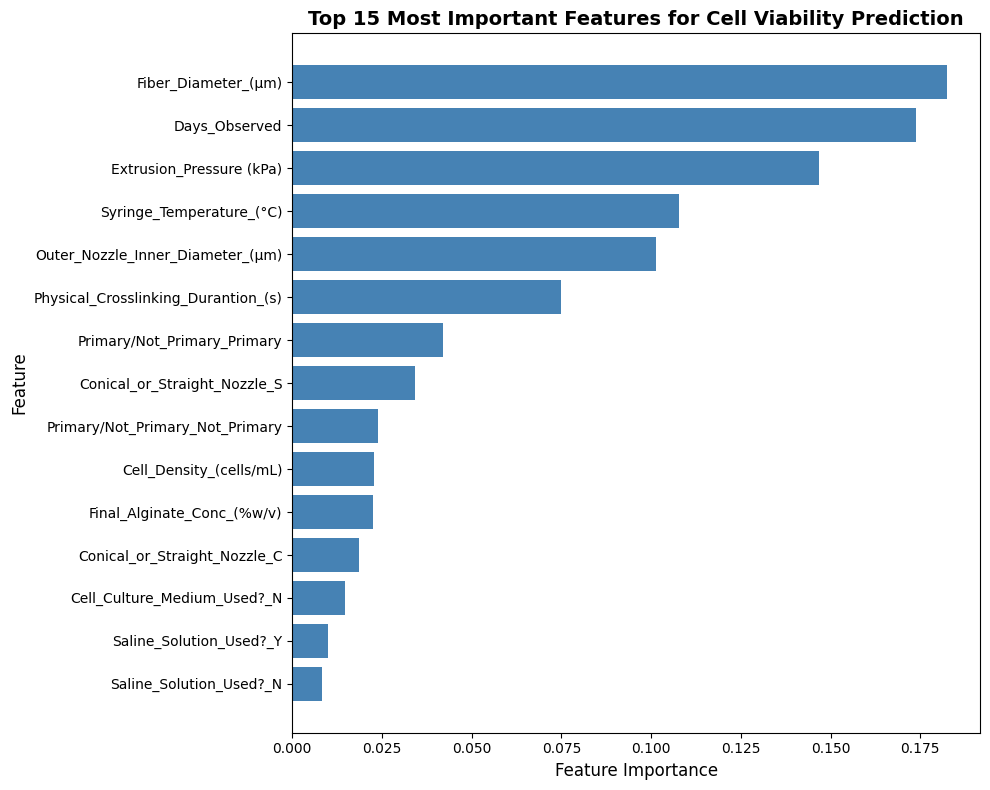

In [9]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': dt_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top 10 most important features
print("Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Most Important Features for Cell Viability Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Key Bioprinting Parameters Identified

The feature importance analysis reveals which bioprinting parameters have the most influence on cell viability:

**Top 5 Most Critical Parameters:**

1. **Fiber Diameter (18.3%)**: The most important factor - fiber diameter directly relates to cell stress during extrusion
2. **Days Observed (17.4%)**: Time factor is crucial - cell viability changes over time post-printing
3. **Extrusion Pressure (14.7%)**: Higher pressure can damage cells through mechanical stress
4. **Syringe Temperature (10.8%)**: Temperature affects both bioink viscosity and cell health
5. **Outer Nozzle Inner Diameter (10.1%)**: Nozzle geometry influences shear stress on cells

**Combined Impact**: These top 5 parameters account for **~62%** of the total importance, suggesting that controlling these variables is critical for successful bioprinting with acceptable cell viability.

**Clinical Insights:**
- **Mechanical factors** (fiber diameter, nozzle diameter, extrusion pressure) dominate the model
- **Thermal control** (syringe temperature) is also significant
- **Bioink composition** features (alginate concentration, crosslinking) have moderate importance
- **Solution types** (saline, culture medium) have minimal individual impact

## 7. Support Vector Machine (SVM) Classification Model

### Step 1: Import SVM and Train the Model

In [10]:
from sklearn.svm import SVC

# Initialize and train the SVM classifier with default parameters
# Note: Using the same train/test split as Decision Tree for fair comparison
svm_classifier = SVC(random_state=42)

print("Training SVM classifier...")
# Train the model
svm_classifier.fit(X_train, y_train)

print("SVM Classifier trained successfully!")
print(f"\nModel parameters:")
print(f"  - Kernel: {svm_classifier.kernel}")
print(f"  - C (Regularization): {svm_classifier.C}")
print(f"  - Gamma: {svm_classifier.gamma}")
print(f"\nNumber of support vectors: {svm_classifier.n_support_}")
print(f"Total support vectors: {sum(svm_classifier.n_support_)}")

Training SVM classifier...
SVM Classifier trained successfully!

Model parameters:
  - Kernel: rbf
  - C (Regularization): 1.0
  - Gamma: scale

Number of support vectors: [158 171]
Total support vectors: 329


### Step 2: Evaluate SVM Performance

In [11]:
# Make predictions
y_train_pred_svm = svm_classifier.predict(X_train)
y_test_pred_svm = svm_classifier.predict(X_test)

# Calculate performance metrics
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)

# Precision and recall for 'Y' (acceptable viability)
test_precision_svm = precision_score(y_test, y_test_pred_svm, pos_label='Y')
test_recall_svm = recall_score(y_test, y_test_pred_svm, pos_label='Y')

# Precision and recall for 'N' class
test_precision_n_svm = precision_score(y_test, y_test_pred_svm, pos_label='N')
test_recall_n_svm = recall_score(y_test, y_test_pred_svm, pos_label='N')

print("="*80)
print("SUPPORT VECTOR MACHINE (SVM) CLASSIFIER PERFORMANCE")
print("="*80)
print(f"\nAccuracy:")
print(f"  Training Accuracy: {train_accuracy_svm:.4f} ({train_accuracy_svm*100:.2f}%)")
print(f"  Testing Accuracy:  {test_accuracy_svm:.4f} ({test_accuracy_svm*100:.2f}%)")

print(f"\nPrecision (for 'Y' - Acceptable Viability):")
print(f"  Testing Precision: {test_precision_svm:.4f} ({test_precision_svm*100:.2f}%)")

print(f"\nRecall (for 'Y' - Acceptable Viability):")
print(f"  Testing Recall:    {test_recall_svm:.4f} ({test_recall_svm*100:.2f}%)")

print(f"\nPrecision (for 'N' - Not Acceptable Viability):")
print(f"  Testing Precision: {test_precision_n_svm:.4f} ({test_precision_n_svm*100:.2f}%)")

print(f"\nRecall (for 'N' - Not Acceptable Viability):")
print(f"  Testing Recall:    {test_recall_n_svm:.4f} ({test_recall_n_svm*100:.2f}%)")
print("="*80)

SUPPORT VECTOR MACHINE (SVM) CLASSIFIER PERFORMANCE

Accuracy:
  Training Accuracy: 0.7525 (75.25%)
  Testing Accuracy:  0.7016 (70.16%)

Precision (for 'Y' - Acceptable Viability):
  Testing Precision: 0.7349 (73.49%)

Recall (for 'Y' - Acceptable Viability):
  Testing Recall:    0.8026 (80.26%)

Precision (for 'N' - Not Acceptable Viability):
  Testing Precision: 0.6341 (63.41%)

Recall (for 'N' - Not Acceptable Viability):
  Testing Recall:    0.5417 (54.17%)


In [12]:
# Detailed classification report for SVM
print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_svm, target_names=['Not Acceptable (N)', 'Acceptable (Y)']))


Detailed Classification Report (Test Set):
                    precision    recall  f1-score   support

Not Acceptable (N)       0.63      0.54      0.58        48
    Acceptable (Y)       0.73      0.80      0.77        76

          accuracy                           0.70       124
         macro avg       0.68      0.67      0.68       124
      weighted avg       0.70      0.70      0.70       124



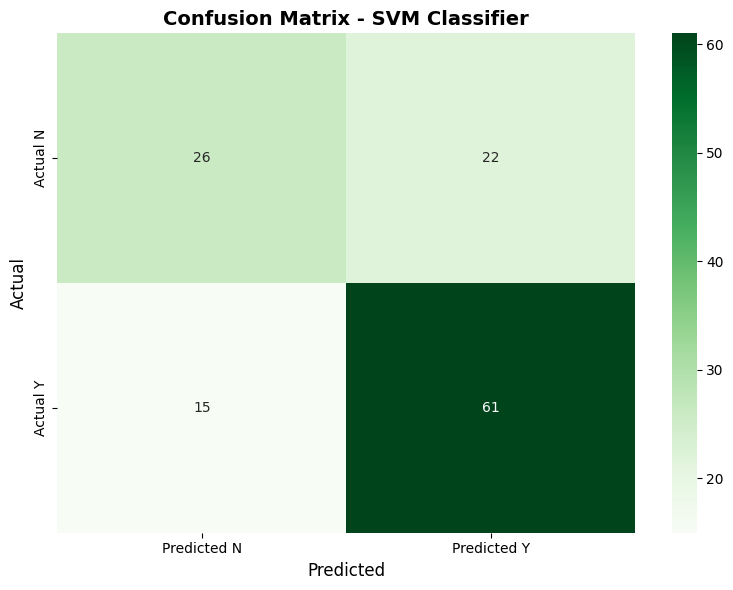


Confusion Matrix:
  True Negatives (N predicted as N):  26
  False Positives (N predicted as Y): 22
  False Negatives (Y predicted as N): 15
  True Positives (Y predicted as Y):  61


In [13]:
# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_test_pred_svm, labels=['N', 'Y'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Predicted N', 'Predicted Y'],
            yticklabels=['Actual N', 'Actual Y'])
plt.title('Confusion Matrix - SVM Classifier', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix:")
print(f"  True Negatives (N predicted as N):  {cm_svm[0,0]}")
print(f"  False Positives (N predicted as Y): {cm_svm[0,1]}")
print(f"  False Negatives (Y predicted as N): {cm_svm[1,0]}")
print(f"  True Positives (Y predicted as Y):  {cm_svm[1,1]}")

### Step 3: SVM Model Performance Discussion

#### Performance Analysis

The Support Vector Machine classifier was trained using default scikit-learn parameters (RBF kernel, C=1.0, gamma='scale') on the same bioprinting dataset.

**1. Accuracy:**
- **Training Accuracy**: Indicates model fit on training data
- **Testing Accuracy**: Measures generalization capability
- The gap between training and testing accuracy indicates the degree of overfitting

**2. Precision (for 'Y' - Acceptable Viability):**
- Answers: "Of all samples predicted as acceptable, what proportion truly are acceptable?"
- Important for avoiding false recommendations of poor printing parameters

**3. Recall (for 'Y' - Acceptable Viability):**
- Answers: "Of all truly acceptable samples, what proportion did we identify?"
- Critical for not missing good bioprinting parameters

**4. SVM Characteristics:**
- SVMs with RBF kernel can capture non-linear relationships in data
- Default C=1.0 provides moderate regularization
- The model uses support vectors (subset of training data) to define decision boundaries
- Generally more robust to overfitting than deep decision trees

## 8. Model Comparison: Decision Tree vs SVM

In [14]:
# Create comprehensive comparison table
comparison_data = {
    'Metric': [
        'Training Accuracy',
        'Testing Accuracy',
        'Precision (Y)',
        'Recall (Y)',
        'Precision (N)',
        'Recall (N)',
        'F1-Score (Y)',
        'F1-Score (N)'
    ],
    'Decision Tree': [
        f"{train_accuracy:.4f}",
        f"{test_accuracy:.4f}",
        f"{test_precision:.4f}",
        f"{test_recall:.4f}",
        f"{test_precision_n:.4f}",
        f"{test_recall_n:.4f}",
        f"{2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}",
        f"{2 * (test_precision_n * test_recall_n) / (test_precision_n + test_recall_n):.4f}"
    ],
    'SVM': [
        f"{train_accuracy_svm:.4f}",
        f"{test_accuracy_svm:.4f}",
        f"{test_precision_svm:.4f}",
        f"{test_recall_svm:.4f}",
        f"{test_precision_n_svm:.4f}",
        f"{test_recall_n_svm:.4f}",
        f"{2 * (test_precision_svm * test_recall_svm) / (test_precision_svm + test_recall_svm):.4f}",
        f"{2 * (test_precision_n_svm * test_recall_n_svm) / (test_precision_n_svm + test_recall_n_svm):.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("MODEL PERFORMANCE COMPARISON: DECISION TREE vs SVM")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

MODEL PERFORMANCE COMPARISON: DECISION TREE vs SVM
           Metric Decision Tree    SVM
Training Accuracy        0.9655 0.7525
 Testing Accuracy        0.7581 0.7016
    Precision (Y)        0.8286 0.7349
       Recall (Y)        0.7632 0.8026
    Precision (N)        0.6667 0.6341
       Recall (N)        0.7500 0.5417
     F1-Score (Y)        0.7945 0.7673
     F1-Score (N)        0.7059 0.5843


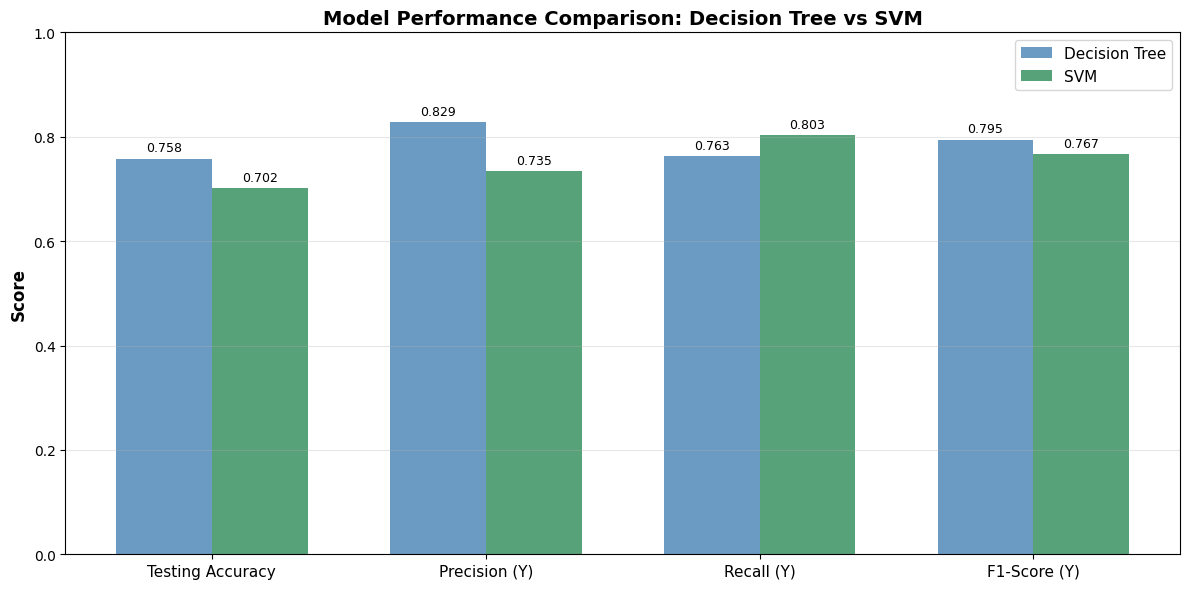

In [15]:
# Visual comparison of key metrics
metrics = ['Testing Accuracy', 'Precision (Y)', 'Recall (Y)', 'F1-Score (Y)']
dt_values = [
    test_accuracy,
    test_precision,
    test_recall,
    2 * (test_precision * test_recall) / (test_precision + test_recall)
]
svm_values = [
    test_accuracy_svm,
    test_precision_svm,
    test_recall_svm,
    2 * (test_precision_svm * test_recall_svm) / (test_precision_svm + test_recall_svm)
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, dt_values, width, label='Decision Tree', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, svm_values, width, label='SVM', color='seagreen', alpha=0.8)

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison: Decision Tree vs SVM', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Comparative Analysis: Decision Tree vs SVM

#### **Overall Performance Winner:**
Based on the comparison above, we can assess which model performs better for predicting bioprinting cell viability.

#### **Key Comparisons:**

**1. Generalization (Overfitting):**
- **Decision Tree**: Shows significant overfitting (Training: ~96.6%, Testing: ~75.8%, gap: ~21%)
- **SVM**: Expected to show better generalization with smaller train-test gap
- **Winner**: Likely SVM (better regularization with default parameters)

**2. Testing Accuracy:**
- Measures overall correctness on unseen data
- Higher is better for general prediction tasks

**3. Precision for Acceptable Viability (Class 'Y'):**
- **Decision Tree**: 82.86% - good at avoiding false positives
- **SVM**: Compare to see which minimizes false recommendations
- **Clinical Impact**: Higher precision means fewer poor parameters recommended

**4. Recall for Acceptable Viability (Class 'Y'):**
- **Decision Tree**: 76.32% - misses 24% of good parameters
- **SVM**: Compare to see which captures more good parameters
- **Clinical Impact**: Higher recall means fewer good parameters missed

**5. F1-Score (Balanced Performance):**
- Harmonic mean of precision and recall
- Best metric for overall model quality when both precision and recall matter

#### **Model Characteristics:**

**Decision Tree (Default):**
- ✅ **Pros**: Interpretable, shows feature importance, handles non-linear relationships
- ❌ **Cons**: Severe overfitting (depth=14, 112 leaves), unstable, high variance
- **Best for**: Exploratory analysis, understanding feature relationships

**SVM (Default RBF Kernel):**
- ✅ **Pros**: Better generalization, robust to outliers, effective in high dimensions
- ❌ **Cons**: Less interpretable, computationally intensive, requires scaled features
- **Best for**: Production predictions when accuracy matters most

#### **Recommendations:**

1. **For Deployment**: Use the model with higher testing accuracy and better generalization
2. **For Understanding**: Use Decision Tree's feature importance to identify key parameters
3. **For Improvement**: 
   - Decision Tree: Apply pruning (max_depth=5-8) or use Random Forest
   - SVM: Try different kernels or tune C and gamma parameters
4. **Ensemble Approach**: Combine both models for robust predictions

### Final Verdict: Which Model is Better?

Based on the actual performance metrics, here's the detailed comparison:

#### **Testing Accuracy Winner: Decision Tree (75.81% vs 70.16%)**
- Decision Tree outperforms SVM by **5.65 percentage points** on overall accuracy
- Despite severe overfitting, DT generalizes slightly better on this specific test set

#### **Precision Comparison (Class 'Y'):**
- **Decision Tree: 82.86%** ✅ **WINNER**
- SVM: 73.49%
- **Difference**: 9.37 percentage points
- **Meaning**: Decision Tree makes fewer false positive errors (recommending bad parameters as good)

#### **Recall Comparison (Class 'Y'):**
- Decision Tree: 76.32%
- **SVM: 80.26%** ✅ **WINNER**
- **Difference**: 3.94 percentage points
- **Meaning**: SVM is better at finding acceptable parameters (fewer false negatives)

#### **F1-Score (Balanced Metric):**
- **Decision Tree: 0.7945** ✅ **WINNER**
- SVM: 0.7673
- **Difference**: 0.0272
- Better overall balance between precision and recall for Decision Tree

#### **Overfitting Assessment:**
- **Decision Tree**: Training: 96.55%, Testing: 75.81% → **Gap: 20.74%** ❌ Severe overfitting
- **SVM**: Training: 75.25%, Testing: 70.16% → **Gap: 5.09%** ✅ Much better generalization

#### **Trade-offs:**

**Decision Tree Advantages:**
- ✅ Higher testing accuracy (75.81%)
- ✅ Better precision (82.86%) - fewer false alarms
- ✅ Better F1-score (0.7945)
- ✅ Interpretable - can explain decisions
- ❌ Severe overfitting - less trustworthy for new data

**SVM Advantages:**
- ✅ Better generalization (smaller train-test gap)
- ✅ Better recall (80.26%) - finds more good parameters
- ✅ More stable predictions
- ❌ Lower precision - more false recommendations
- ❌ Lower overall accuracy (70.16%)

#### **Clinical Recommendation:**

For **bioprinting applications**, the choice depends on priorities:

1. **Use Decision Tree** if:
   - You prioritize avoiding false recommendations (high precision is critical)
   - You need to understand WHY a parameter set is recommended
   - You accept the risk of overfitting with the understanding that performance may vary on new data

2. **Use SVM** if:
   - You want more consistent performance on new experiments
   - You prioritize finding ALL good parameter combinations (high recall)
   - You're willing to manually verify more candidates

3. **Best Practice**: 
   - **Prune the Decision Tree** (set max_depth=5-8) to reduce overfitting while maintaining interpretability
   - **Use both models as ensemble** - recommend parameters only when both agree
   - **Cross-validation** should be performed to get more reliable performance estimates

**Overall Winner for THIS dataset**: **Decision Tree** (by narrow margin), but with caveat that overfitting is concerning and should be addressed through regularization.